<a href="https://colab.research.google.com/github/Nelson-iitp/2121CS07_CS575/blob/main/CS575_EndSem/A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
pip show statsmodels

Name: statsmodels
Version: 0.12.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: None
Author-email: None
License: BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, pandas, patsy, scipy
Required-by: plotnine


# __ statsmodels==0.12.2

In [ ]:
pip install statsmodels==0.12.2

# IMPORTS

In [ ]:
import datetime
import os
import random
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import statsmodels.tsa as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, RepeatVector, TimeDistributed, Flatten, LSTM

from tensorflow.keras import Model

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter('ignore', ConvergenceWarning)
#warnings.simplefilter('ignore', tsa.stattools.warnings.FutureWarning)
warnings.simplefilter('ignore', UserWarning)


# REQUIRED

In [ ]:
# define adf and kpss testing

def stationary_test(ds, p_threshold , details = False):
  res=""
  res += '\nADF-Test Hypothesis :: Series is Non-Stationary\n'
  timeseries = ds.dropna()
  dftest =  tsa.stattools.adfuller(timeseries, autolag='AIC') #  regression='c'
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] =  (value, getHres(dftest[0],value) )
  if details:
    res+=str(dfoutput)+"\n"
  #if dftest[1]<p_threshold: # hypothesis is false = Rejected
  #if dftest[1]>p_threshold: # hypothesis is true = cannot reject
  resb =  (dftest[1]>=p_threshold)
  res+= "RESULT :: Hypothesis is "+str( resb )
  res+='\n'
#def kpss_test(ds, p_threshold , details = False):
  res1=""
  res1 += '\nKPSS-Test Hypothesis :: Series is Trend-Stationary\n'
  timeseries = ds.dropna()
  kpsstest = tsa.stattools.kpss(timeseries, regression='ct')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] =  (value, getHres(value,kpsstest[0]) )
  
  if details:
    res1+=str(kpss_output)+"\n"

  #if kpsstest[1]<p_threshold: # hypothesis is false = Rejected
  #if kpsstest[1]>p_threshold: # hypothesis is true = cannot reject
  resb1 =  (kpsstest[1]>=p_threshold)
  res1+= "RESULT :: Hypothesis is "+str( resb1 )


  return res, resb, dftest[1], res1, resb1, kpsstest[1]

def getHres(test_stat, crit_val):
  if test_stat<crit_val:
    return "Hypothesis: False"
  else:
    return "Hypothesis: True"


# plot Autocorr and Partial Autocorr ------------------

def plotCF(Y, Lags, lim_y):
  fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,8))
  ax1.set_xticks(np.arange(1,Lags,5 ))
  #ax1.set_xticklabels( [] )
  ax1.grid(axis='x')
  ax2.set_xticks(np.arange(1,Lags,5 ))
  #ax2.set_xticklabels( [] )
  ax2.grid(axis='x')
  if lim_y:
      ax1.set_ylim((-.21,.21))
      ax2.set_ylim((-.21,.21))
  plot_acf(Y,lags=Lags,zero=True,ax=ax1)
  plot_pacf(Y,lags=Lags,zero=True,ax=ax2)
  
  plt.show()

def plotshow(Y, Lags):

  scatter_x = np.arange(0,Lags+1,1)
  #print('Lags/Scatter =', Lags,'/', len(scatter_x))
    # mean subtracted
  ACONVF = tsa.stattools.acovf(Y,
            demean= True,
            nlag=Lags
            )
  ACONVF1 = tsa.stattools.acovf(Y, 
            demean= False,
            nlag=Lags
            )
  #print('ACONVF = #',len(ACONVF))
  plt.figure('ACONVF',figsize=(12,6))
  plt.title('Auto-Covariance')

  plt.scatter(scatter_x, ACONVF, color='tab:green')
  plt.plot(ACONVF, color='tab:green',label='De-meaned')
  plt.plot(ACONVF1, color='tab:pink',label='Mean Shifted')

  plt.hlines(0,0,Lags+1,color='tab:green',linewidth=0.7)
  plt.legend()
  plt.show()

  # <<------------ calculate ACF PACF -----------------------------
  ACF,xACF = tsa.stattools.acf(Y,
            unbiased=False,
            nlags=Lags,
            alpha = 0.1 
            )
  PACF,xPACF = tsa.stattools.pacf(Y, 
            nlags=Lags,
            alpha = 0.1 
            )

  _fig,_ax = plt.subplots( 2,1, figsize=(12,6))

  _ax[0].set_ylim(-0.21,0.21)
  _ax[0].set_title('ACF')
  _ax[0].plot(ACF, color='tab:red', linewidth=0.3)
  _ax[0].scatter(scatter_x, ACF, color='tab:red',marker='.', label='ACF')
  #_ax[0].plot(xACF[:,0], color='black', linewidth=0.5)
  #_ax[0].plot(xACF[:,1], color='black', linewidth=0.5)
  _ax[0].bar(scatter_x,ACF,width=0.2, color='tab:red')
  _ax[0].hlines(0,0,Lags+1,color='tab:gray',linewidth=0.5)
  _ax[0].vlines(1,-1.1,1.1,color='tab:gray',linewidth=0.7)
  
  #_ax[0].legend()

  _ax[1].set_ylim(-1.1,1.1)
  _ax[1].set_title('PACF')
  _ax[1].plot(PACF, color='tab:blue', linewidth=0.3)
  _ax[1].scatter(scatter_x, PACF, color='tab:blue',marker='.', label='PACF')
  #_ax[1].plot(xPACF[:,0], color='black', linewidth=0.5)
  #_ax[1].plot(xPACF[:,1], color='black', linewidth=0.5)
  _ax[1].bar(scatter_x,PACF,width=0.2, color='tab:blue')
  _ax[1].hlines(0,0,Lags+1,color='tab:gray',linewidth=0.5)
  _ax[1].vlines(1,-1.1,1.1,color='tab:gray',linewidth=0.7)
  #_ax[1].legend()

  plt.show()


#  DATA 2 CSV

In [ ]:
############################################### 
#download data from yahoo finance 
############################################### 
##data source: http://finance.yahoo.com/ 

 
from pandas_datareader import data as pdr 
from datetime import datetime 
#download data 
ibm = pdr.DataReader('IBM', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30)).to_csv('IBM.csv', sep=',')   
aapl = pdr.DataReader('AAPL', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30)).to_csv('AAPL.csv', sep=',')   
fb = pdr.DataReader('FB', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30)).to_csv('FB.csv', sep=',')  
googl = pdr.DataReader('GOOGL', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30)).to_csv('GOOGL.csv', sep=',')  



# Load Data

In [ ]:
dict_pd = {
    'IBM':pd.read_csv("IBM.csv"),
    'AAPL':pd.read_csv("AAPL.csv"),
    'FB':pd.read_csv("FB.csv"),
    'GOOGL':pd.read_csv("GOOGL.csv")}
xvar = 'Close' # 'Adj Close'
fvar = 'Final'
fgs=(20,5)

# Stock Select : FB

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


         Date       High        Low       Open      Close    Volume  Adj Close
0  2014-08-01  73.220001  71.550003  72.220001  72.360001  43535000  72.360001
1  2014-08-04  73.879997  72.360001  72.360001  73.510002  30777000  73.510002
2  2014-08-05  73.589996  72.180000  73.199997  72.690002  34986000  72.690002
FB 589


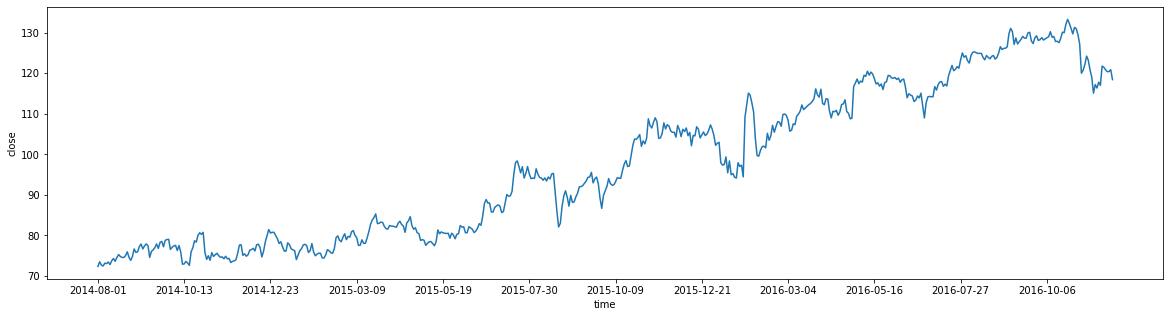

In [ ]:
sel_stock = 'FB'
sel_pd = dict_pd[sel_stock]
print(sel_pd.head(3))
N = len(sel_pd)
print(sel_stock,N )

# plot selected stock
plt.figure(figsize=fgs)
plt.plot(sel_pd["Date"], sel_pd[xvar])
plt.xticks(np.arange(0,N, 50), sel_pd['Date'][0:N:50])
plt.xlabel("time")
plt.ylabel("close")
plt.show()

## Plot Record, ACF, PACF



 FB ==========================================>


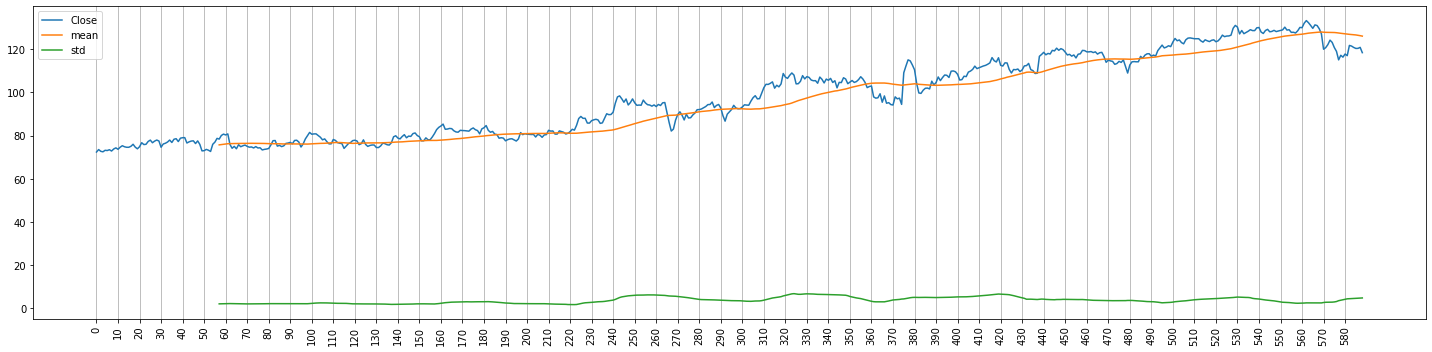

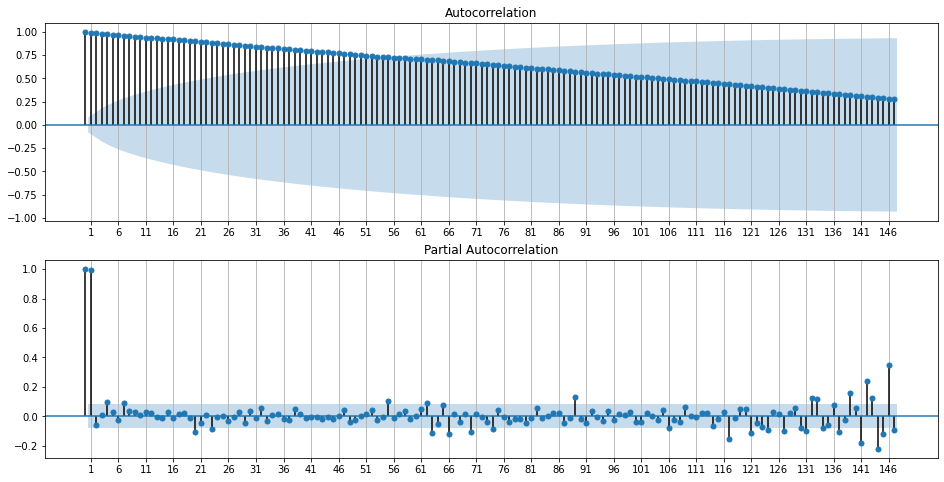

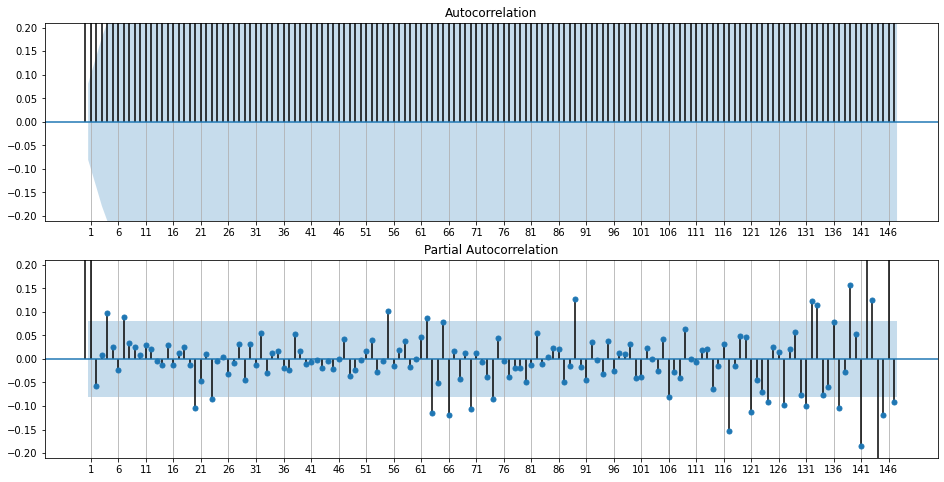

In [ ]:
print('\n\n',sel_stock,'==========================================>')
rm = int(0.1*N)

df = sel_pd[[xvar]].copy()
df['mean'] = df[xvar].rolling(rm).mean()
df['std'] =  df[xvar].rolling(rm).std()

df.plot(figsize=[20,5])
plt.xticks(np.arange(0,N,10), rotation=90)  #<---- interval of 10 obs
plt.grid(axis='x')
plt.tight_layout()
plt.show()


clag = int(.25*N)
plotCF(sel_pd[xvar], clag, False )
plotCF(sel_pd[xvar], clag, True )

## Seasonal Decompose

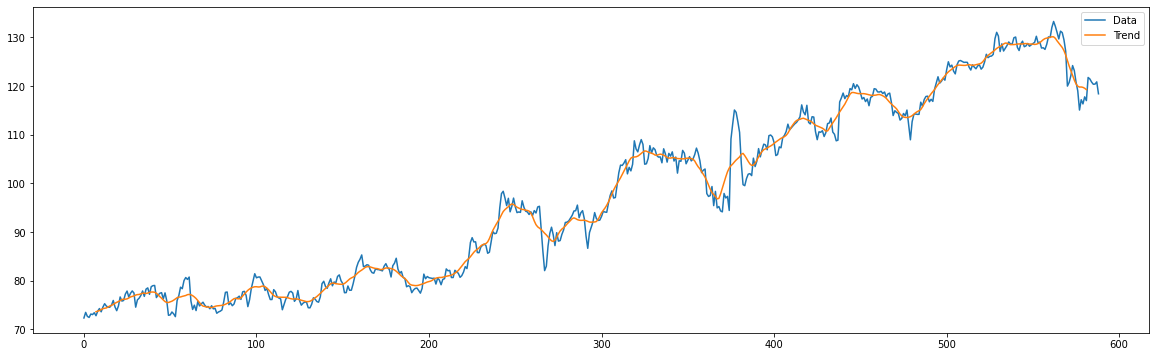

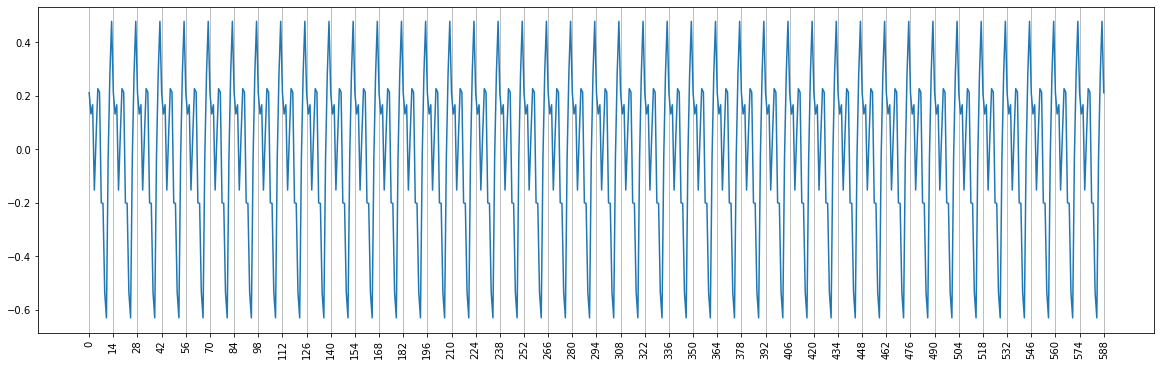

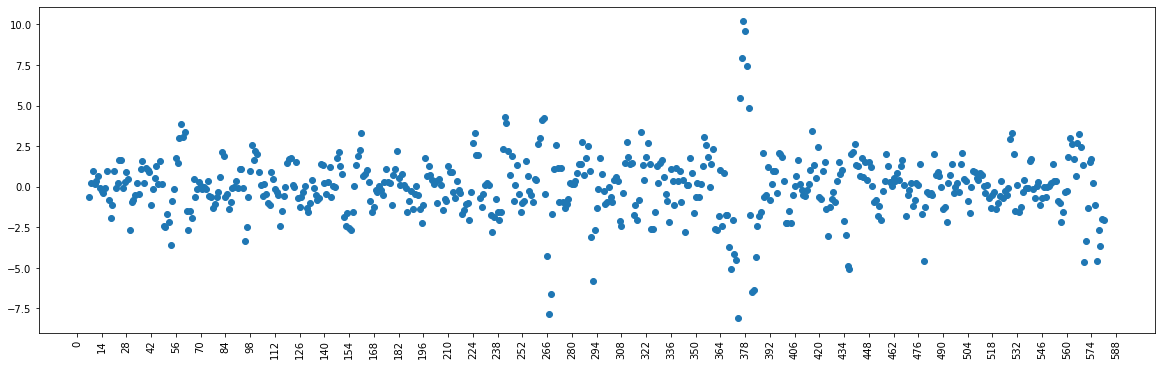

In [ ]:
dfreq=14
res = sm.tsa.seasonal_decompose(sel_pd[xvar],period=dfreq)
orig, season, trend, residual = res.observed, res.seasonal, res.trend, res.resid
xrng = np.arange(0,res.nobs[0],1)
plt.figure(figsize=(20,6))
plt.plot(orig,label='Data')
plt.plot(trend,label='Trend')
plt.legend()
plt.show()
plt.figure(figsize=(20,6))
plt.plot(season)
plt.xticks(np.arange(0,N,dfreq), rotation=90)  #<---- interval of 10 obs
plt.grid(axis='x')
plt.show()
plt.figure(figsize=(20,6))
plt.scatter(residual.keys(), residual)
plt.xticks(np.arange(0,N,dfreq), rotation=90) 
#plt.plot(residual)
plt.show()


## Check Stationarity

Case 1: Both tests conclude that the series is not stationary -> series is not stationary

Case 2: Both tests conclude that the series is stationary -> series is stationary

Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [ ]:
print('\n\n',sel_stock,'==========================================>')

resA, resbA, dftest_, resK, resbK, kpsstest_ = stationary_test(sel_pd[xvar] , 0.05, details=True)
print(resA,'\n',resK)
print('\n Final Result::')
if not resbA: # ADF = stationary

    if resbK:   # KPSS = stationary
        print('Case 2: series is stationary\n')

    else:       # KPSS = non-stationary
        print('Case 4: difference stationary, use differencing to make series stationary\n')

else:   # ADF = non-stationary

    if not resbK: # KPSS = non-stationary
        print('Case 1: series is not stationary\n')

    else:          # KPSS = stationary
        print('Case 3: trend stationary, remove the trend to make series strict stationary\n')




 FB ==========================================>

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                              -0.966644
p-value                                                      0.765235
#Lags Used                                                          6
Number of Observations Used                                       582
Critical Value (1%)            (-3.441635870156286, Hypothesis: True)
Critical Value (5%)            (-2.866518854162241, Hypothesis: True)
Critical Value (10%)           (-2.569421591856497, Hypothesis: True)
dtype: object
RESULT :: Hypothesis is True
 
 
KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                              0.28127
p-value                                        0.01
Lags Used                                        19
Critical Value (10%)     (0.119, Hypothesis: False)
Critical Value (5%)      (0.146, Hypothesis: False)
Critical Value (2.5%)    (0.176, Hypothesis: False)
C

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



## Convert 2 Stationary

In [ ]:
diff_period = 2
sel_pd[fvar] =  sel_pd[xvar].diff(periods=diff_period).dropna()
print('Differencing with lag =', diff_period)

sel_pd.head()

Differencing with lag = 2


,Date,High,Low,Open,Close,Volume,Adj Close,Final
0,2014-08-01,73.220001,71.550003,72.220001,72.360001,43535000,72.360001,NaN
1,2014-08-04,73.879997,72.360001,72.360001,73.510002,30777000,73.510002,NaN
2,2014-08-05,73.589996,72.180000,73.199997,72.690002,34986000,72.690002,0.330002
3,2014-08-06,73.720001,71.790001,72.019997,72.470001,30986000,72.470001,-1.040001
4,2014-08-07,74.000000,72.699997,73.000000,73.169998,38141000,73.169998,0.479996


### Recheck



 FB ==========================================>


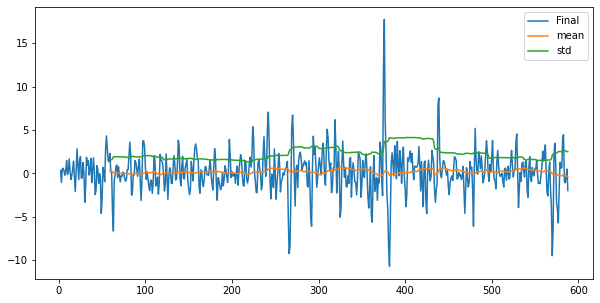

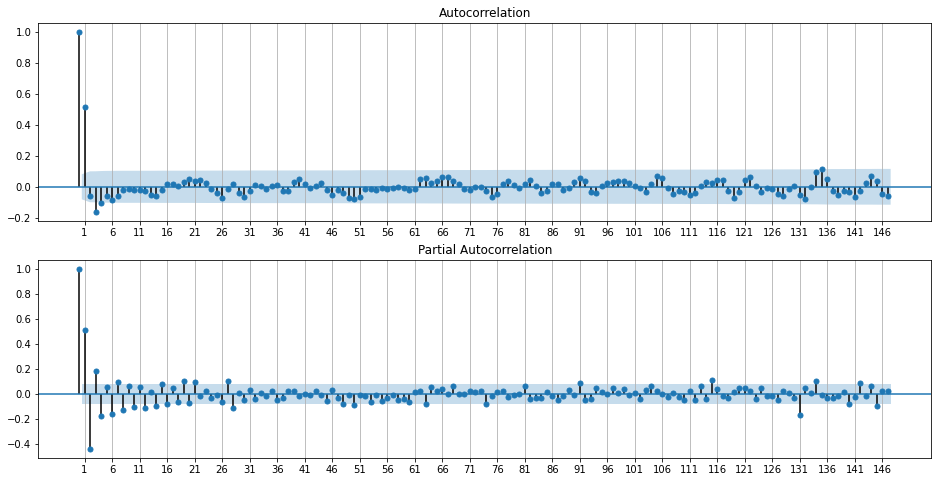

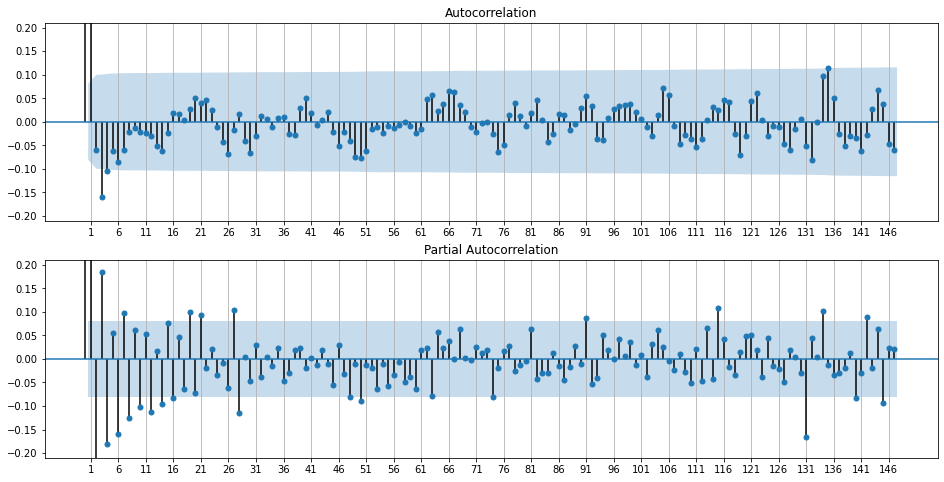


ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -6.07686
p-value                                                     1.11618e-07
#Lags Used                                                           19
Number of Observations Used                                         567
Critical Value (1%)             (-3.441935806025943, Hypothesis: False)
Critical Value (5%)            (-2.8666509204896093, Hypothesis: False)
Critical Value (10%)           (-2.5694919649816947, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
 
 
KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0556017
p-value                                        0.1
Lags Used                                       19
Critical Value (10%)     (0.119, Hypothesis: True)
Critical Value (5%)      (0.146, Hypothesis: True)
Critical Value (2.5%)    (0.176, Hypothesis: True)
Critical Value (1%)      (0.216, Hypothesi

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



In [ ]:
print('\n\n',sel_stock,'==========================================>')
df = sel_pd[[fvar]].dropna().copy()
df['mean'] = df[fvar].rolling(rm).mean()
df['std'] = df[fvar].rolling(rm).std()
df.plot(figsize=[10,5])
plt.show()

plotCF(df[fvar], clag, False )
plotCF(df[fvar], clag, True )


resA, resbA, dftest_, resK, resbK, kpsstest_ = stationary_test(df[fvar] , 0.05, details=True)
print(resA,'\n',resK)
print('\n Final Result::')
if not resbA: # ADF = stationary

    if resbK:   # KPSS = stationary
        print('Case 2: series is stationary\n')

    else:       # KPSS = non-stationary
        print('Case 4: difference stationary, use differencing to make series stationary\n')

else:   # ADF = non-stationary

    if not resbK: # KPSS = non-stationary
        print('Case 1: series is not stationary\n')

    else:          # KPSS = stationary
        print('Case 3: trend stationary, remove the trend to make series strict stationary\n')


## *Comments*

Serise is Non-Stationary and has trend

Can be converted to stationary serise by differencing with lag=2 

PACF shows significant lags upto 16 

ACF shows sfignificant lags upto 4

USE ARIMA(16,2,4)



---



# Stock Select : AAPL

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


         Date       High        Low  ...      Close       Volume  Adj Close
0  2014-08-01  24.155001  23.702499  ...  24.032499  194044000.0  21.657644
1  2014-08-04  24.145000  23.792500  ...  23.897499  159832000.0  21.535982
2  2014-08-05  23.920000  23.590000  ...  23.780001  223732000.0  21.430096

[3 rows x 7 columns]
AAPL 589


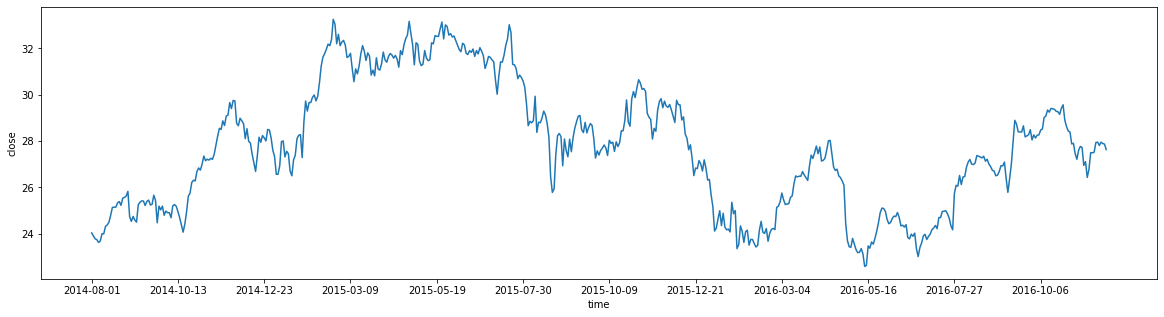

In [ ]:
sel_stock = 'AAPL'
sel_pd = dict_pd[sel_stock]
print(sel_pd.head(3))
N = len(sel_pd)
print(sel_stock,N )

# plot selected stock
plt.figure(figsize=fgs)
plt.plot(sel_pd["Date"], sel_pd[xvar])
plt.xticks(np.arange(0,N, 50), sel_pd['Date'][0:N:50])
plt.xlabel("time")
plt.ylabel("close")
plt.show()

## Plot Record, ACF, PACF



 AAPL ==========================================>


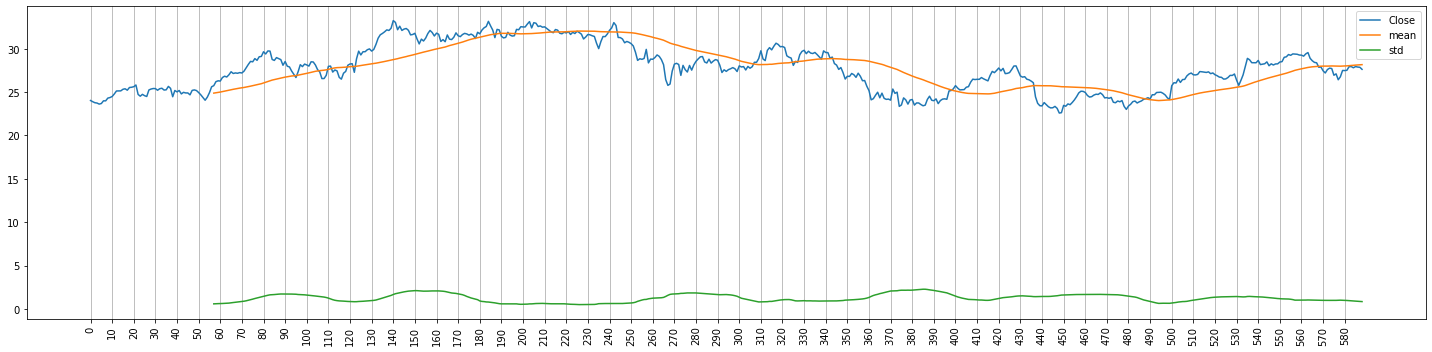

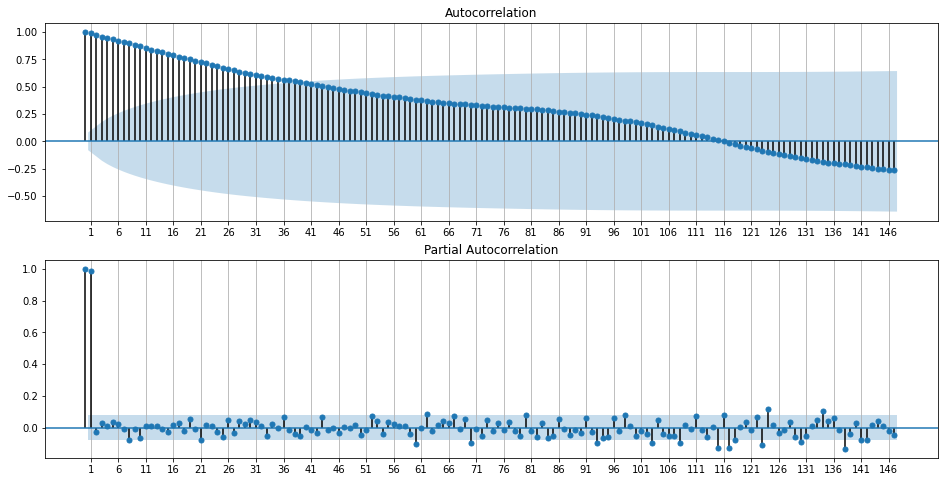

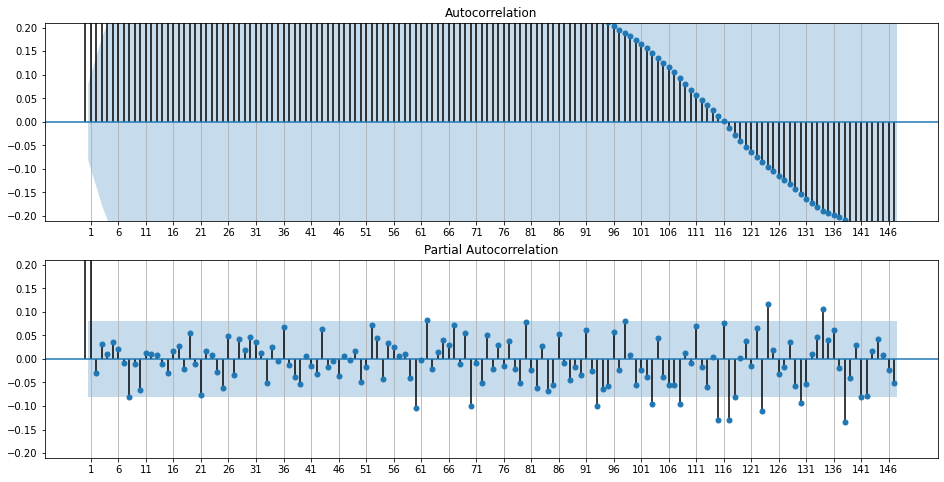

In [ ]:
print('\n\n',sel_stock,'==========================================>')
rm = int(0.1*N)

df = sel_pd[[xvar]].copy()
df['mean'] = df[xvar].rolling(rm).mean()
df['std'] =  df[xvar].rolling(rm).std()

df.plot(figsize=[20,5])
plt.xticks(np.arange(0,N,10), rotation=90)  #<---- interval of 10 obs
plt.grid(axis='x')
plt.tight_layout()
plt.show()


clag = int(.25*N)
plotCF(sel_pd[xvar], clag, False )
plotCF(sel_pd[xvar], clag, True )

## Seasonal Decompose

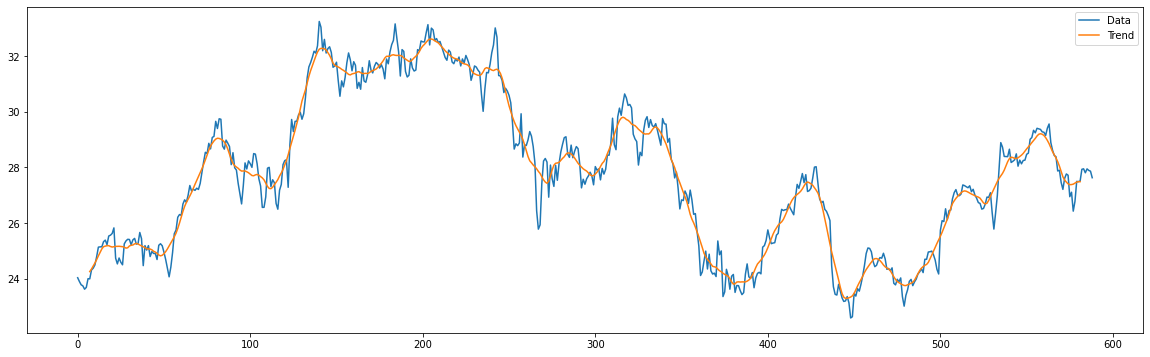

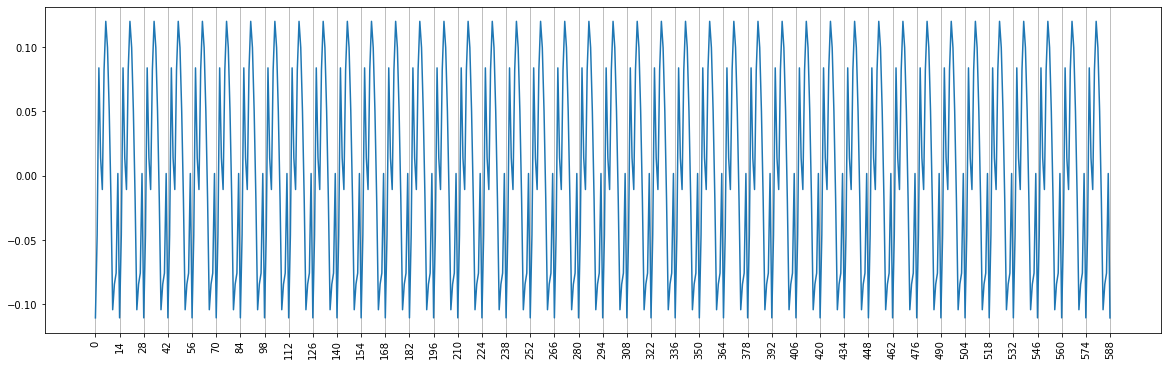

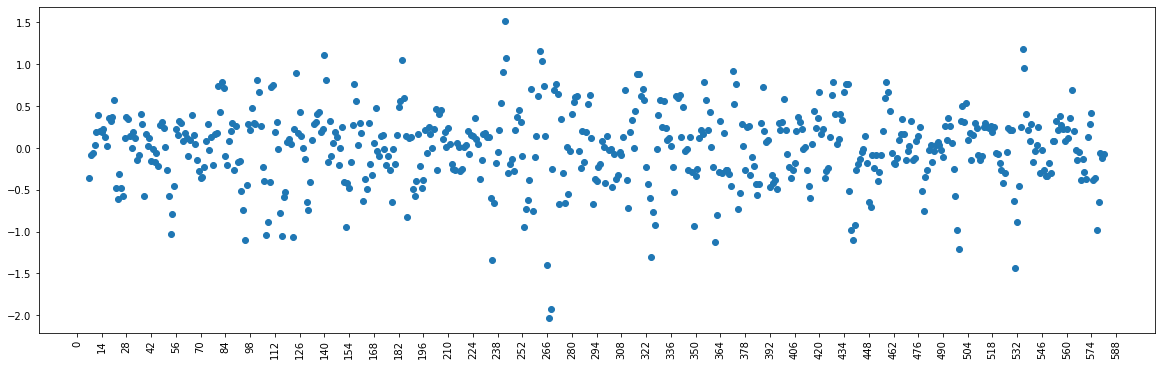

In [ ]:
dfreq=14
res = sm.tsa.seasonal_decompose(sel_pd[xvar],period=dfreq)
orig, season, trend, residual = res.observed, res.seasonal, res.trend, res.resid
xrng = np.arange(0,res.nobs[0],1)
plt.figure(figsize=(20,6))
plt.plot(orig,label='Data')
plt.plot(trend,label='Trend')
plt.legend()
plt.show()
plt.figure(figsize=(20,6))
plt.plot(season)
plt.xticks(np.arange(0,N,dfreq), rotation=90)  #<---- interval of 10 obs
plt.grid(axis='x')
plt.show()
plt.figure(figsize=(20,6))
plt.scatter(residual.keys(), residual)
plt.xticks(np.arange(0,N,dfreq), rotation=90) 
#plt.plot(residual)
plt.show()


## Check Stationarity

Case 1: Both tests conclude that the series is not stationary -> series is not stationary

Case 2: Both tests conclude that the series is stationary -> series is stationary

Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [ ]:
print('\n\n',sel_stock,'==========================================>')

resA, resbA, dftest_, resK, resbK, kpsstest_ = stationary_test(sel_pd[xvar] , 0.05, details=True)
print(resA,'\n',resK)
print('\n Final Result::')
if not resbA: # ADF = stationary

    if resbK:   # KPSS = stationary
        print('Case 2: series is stationary\n')

    else:       # KPSS = non-stationary
        print('Case 4: difference stationary, use differencing to make series stationary\n')

else:   # ADF = non-stationary

    if not resbK: # KPSS = non-stationary
        print('Case 1: series is not stationary\n')

    else:          # KPSS = stationary
        print('Case 3: trend stationary, remove the trend to make series strict stationary\n')




 AAPL ==========================================>

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -2.1706
p-value                                                       0.217087
#Lags Used                                                           0
Number of Observations Used                                        588
Critical Value (1%)              (-3.44152019959894, Hypothesis: True)
Critical Value (5%)            (-2.8664679191981297, Hypothesis: True)
Critical Value (10%)            (-2.569394451038919, Hypothesis: True)
dtype: object
RESULT :: Hypothesis is True
 
 
KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                             0.366657
p-value                                        0.01
Lags Used                                        19
Critical Value (10%)     (0.119, Hypothesis: False)
Critical Value (5%)      (0.146, Hypothesis: False)
Critical Value (2.5%)    (0.176, Hypothesis:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



## Convert 2 Stationary

In [ ]:
diff_period = 2
sel_pd[fvar] =  sel_pd[xvar].diff(periods=diff_period).dropna()
print('Differencing with lag =', diff_period)

sel_pd.head()

Differencing with lag = 2


,Date,High,Low,Open,Close,Volume,Adj Close,Final
0,2014-08-01,24.155001,23.702499,23.725000,24.032499,194044000.0,21.657644,NaN
1,2014-08-04,24.145000,23.792500,24.092501,23.897499,159832000.0,21.535982,NaN
2,2014-08-05,23.920000,23.590000,23.840000,23.780001,223732000.0,21.430096,-0.252499
3,2014-08-06,23.870001,23.677500,23.687500,23.740000,154232000.0,21.394049,-0.157499
4,2014-08-07,23.987499,23.525000,23.732500,23.620001,186844000.0,21.391787,-0.160000


### Recheck



 AAPL ==========================================>


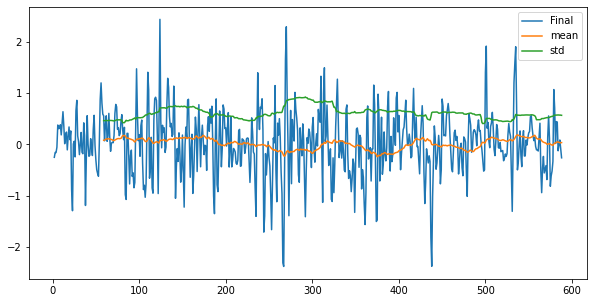

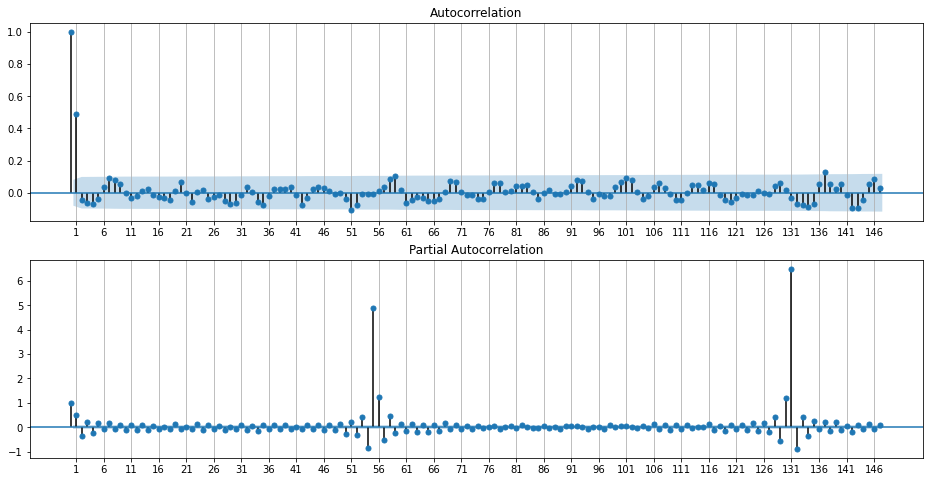

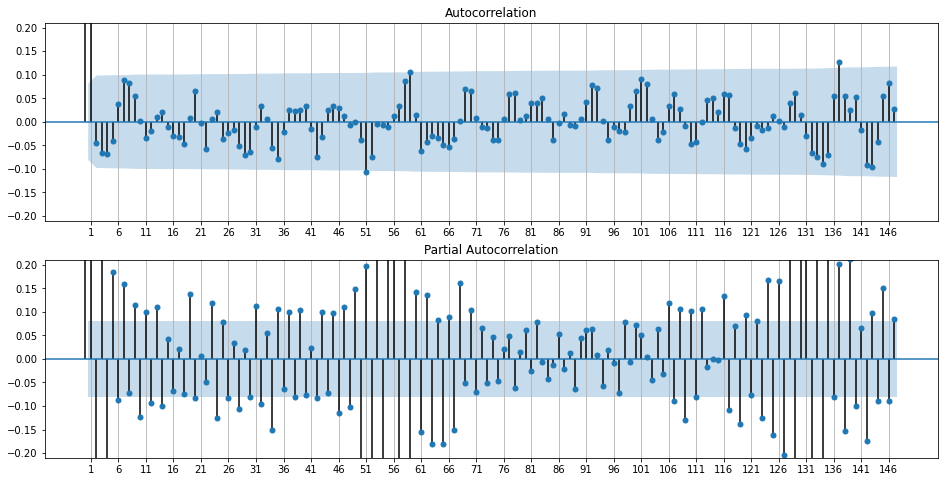


ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -5.22369
p-value                                                     7.86399e-06
#Lags Used                                                           19
Number of Observations Used                                         567
Critical Value (1%)             (-3.441935806025943, Hypothesis: False)
Critical Value (5%)            (-2.8666509204896093, Hypothesis: False)
Critical Value (10%)           (-2.5694919649816947, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
 
 
KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0923382
p-value                                        0.1
Lags Used                                       19
Critical Value (10%)     (0.119, Hypothesis: True)
Critical Value (5%)      (0.146, Hypothesis: True)
Critical Value (2.5%)    (0.176, Hypothesis: True)
Critical Value (1%)      (0.216, Hypothesi

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



In [ ]:
print('\n\n',sel_stock,'==========================================>')
df = sel_pd[[fvar]].dropna().copy()
df['mean'] = df[fvar].rolling(rm).mean()
df['std'] = df[fvar].rolling(rm).std()
df.plot(figsize=[10,5])
plt.show()

plotCF(df[fvar], clag, False )
plotCF(df[fvar], clag, True )


resA, resbA, dftest_, resK, resbK, kpsstest_ = stationary_test(df[fvar] , 0.05, details=True)
print(resA,'\n',resK)
print('\n Final Result::')
if not resbA: # ADF = stationary

    if resbK:   # KPSS = stationary
        print('Case 2: series is stationary\n')

    else:       # KPSS = non-stationary
        print('Case 4: difference stationary, use differencing to make series stationary\n')

else:   # ADF = non-stationary

    if not resbK: # KPSS = non-stationary
        print('Case 1: series is not stationary\n')

    else:          # KPSS = stationary
        print('Case 3: trend stationary, remove the trend to make series strict stationary\n')


## *Comments*

Serise is Non-Stationary and has trend

Can be converted to stationary serise by differencing with lag=2 

PACF shows significant lags upto 14 

ACF shows sfignificant lags upto 1

USE ARIMA(14,2,1)



---



# Stock Select : IBM

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


         Date        High         Low  ...       Close     Volume   Adj Close
0  2014-08-01  191.500000  188.860001  ...  189.149994  5181100.0  143.561371
1  2014-08-04  189.949997  188.600006  ...  189.639999  2125900.0  143.933304
2  2014-08-05  189.199997  186.440002  ...  187.100006  3307900.0  142.005493

[3 rows x 7 columns]
IBM 589


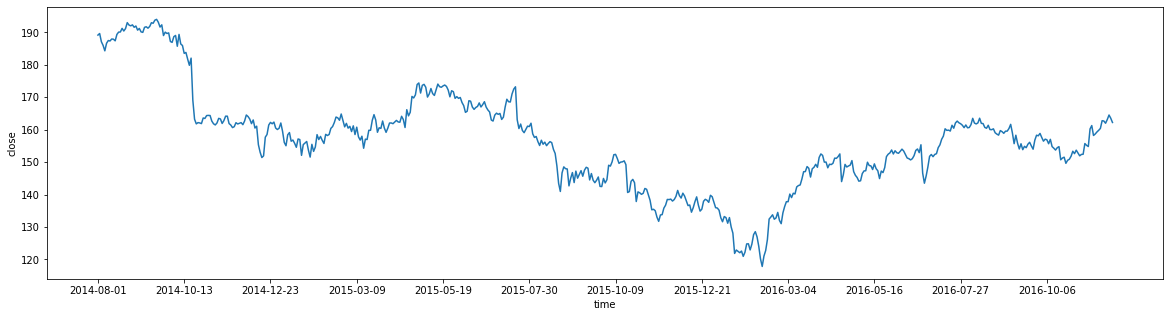

In [ ]:
sel_stock = 'IBM'
sel_pd = dict_pd[sel_stock]
print(sel_pd.head(3))
N = len(sel_pd)
print(sel_stock,N )

# plot selected stock
plt.figure(figsize=fgs)
plt.plot(sel_pd["Date"], sel_pd[xvar])
plt.xticks(np.arange(0,N, 50), sel_pd['Date'][0:N:50])
plt.xlabel("time")
plt.ylabel("close")
plt.show()

## Plot Record, ACF, PACF



 IBM ==========================================>


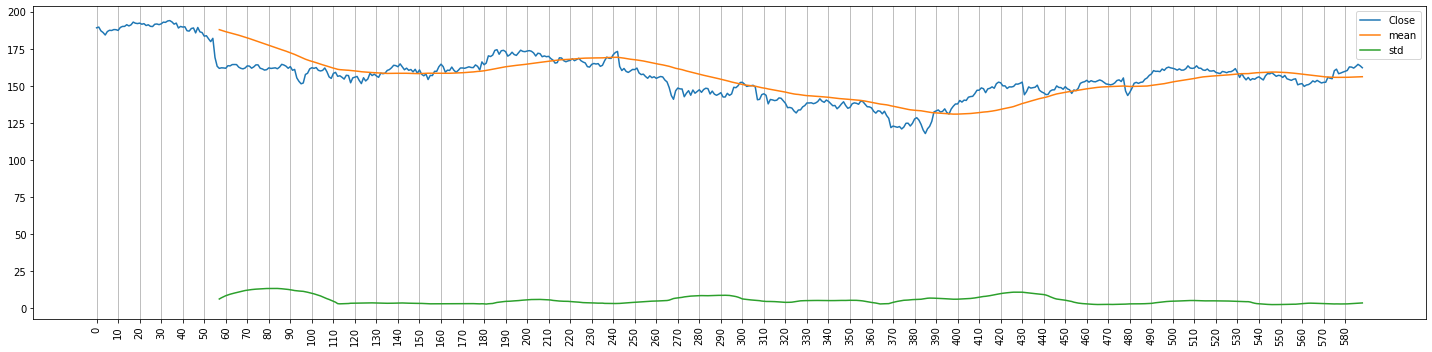

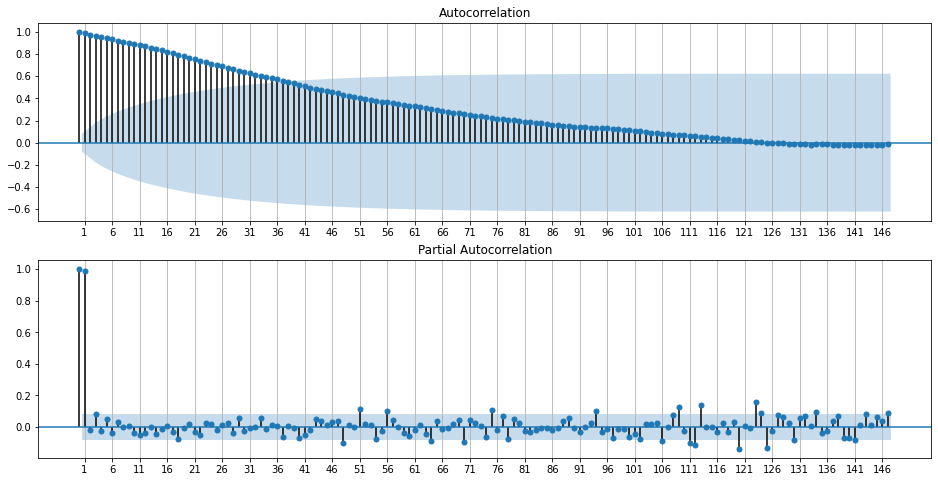

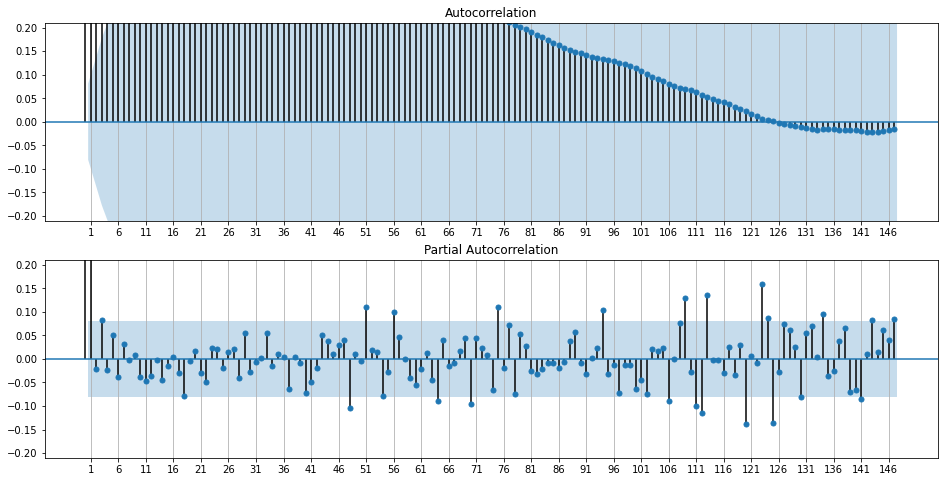

In [ ]:
print('\n\n',sel_stock,'==========================================>')
rm = int(0.1*N)

df = sel_pd[[xvar]].copy()
df['mean'] = df[xvar].rolling(rm).mean()
df['std'] =  df[xvar].rolling(rm).std()

df.plot(figsize=[20,5])
plt.xticks(np.arange(0,N,10), rotation=90)  #<---- interval of 10 obs
plt.grid(axis='x')
plt.tight_layout()
plt.show()


clag = int(.25*N)
plotCF(sel_pd[xvar], clag, False )
plotCF(sel_pd[xvar], clag, True )

## Seasonal Decompose

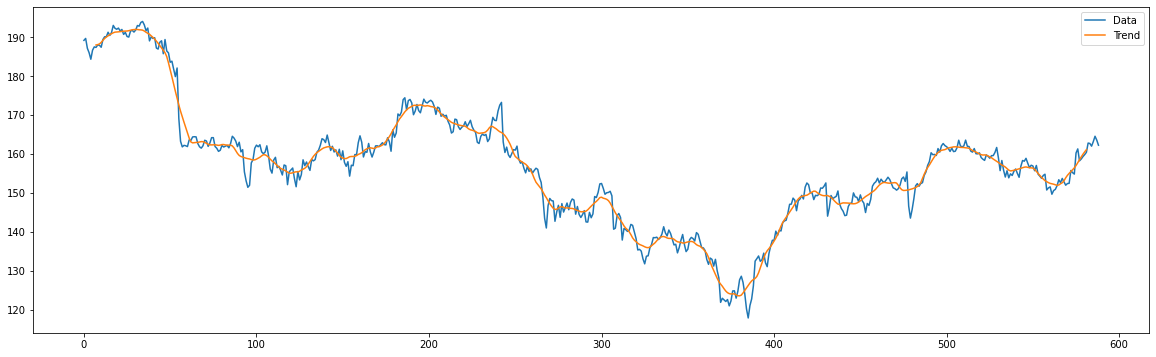

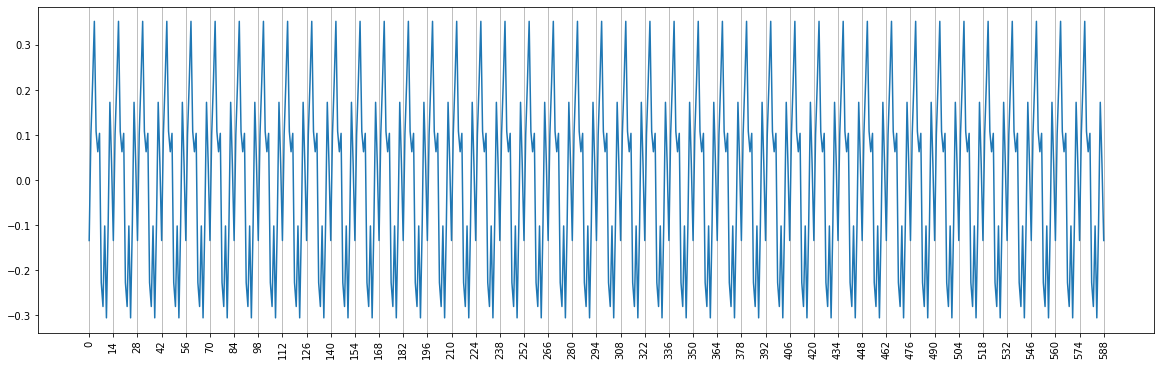

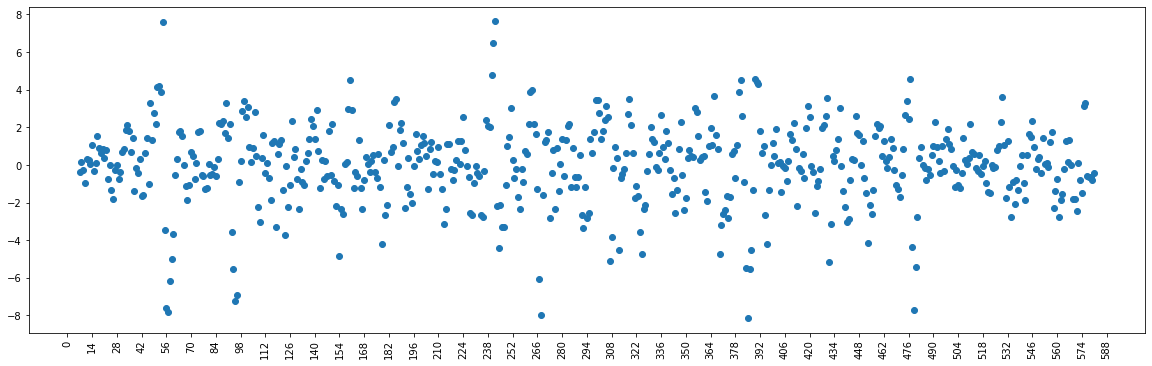

In [ ]:
dfreq=14
res = sm.tsa.seasonal_decompose(sel_pd[xvar],period=dfreq)
orig, season, trend, residual = res.observed, res.seasonal, res.trend, res.resid
xrng = np.arange(0,res.nobs[0],1)
plt.figure(figsize=(20,6))
plt.plot(orig,label='Data')
plt.plot(trend,label='Trend')
plt.legend()
plt.show()
plt.figure(figsize=(20,6))
plt.plot(season)
plt.xticks(np.arange(0,N,dfreq), rotation=90)  #<---- interval of 10 obs
plt.grid(axis='x')
plt.show()
plt.figure(figsize=(20,6))
plt.scatter(residual.keys(), residual)
plt.xticks(np.arange(0,N,dfreq), rotation=90) 
#plt.plot(residual)
plt.show()


## Check Stationarity

Case 1: Both tests conclude that the series is not stationary -> series is not stationary

Case 2: Both tests conclude that the series is stationary -> series is stationary

Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [ ]:
print('\n\n',sel_stock,'==========================================>')

resA, resbA, dftest_, resK, resbK, kpsstest_ = stationary_test(sel_pd[xvar] , 0.05, details=True)
print(resA,'\n',resK)
print('\n Final Result::')
if not resbA: # ADF = stationary

    if resbK:   # KPSS = stationary
        print('Case 2: series is stationary\n')

    else:       # KPSS = non-stationary
        print('Case 4: difference stationary, use differencing to make series stationary\n')

else:   # ADF = non-stationary

    if not resbK: # KPSS = non-stationary
        print('Case 1: series is not stationary\n')

    else:          # KPSS = stationary
        print('Case 3: trend stationary, remove the trend to make series strict stationary\n')




 IBM ==========================================>

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                -2.27927
p-value                                                        0.17874
#Lags Used                                                           0
Number of Observations Used                                        588
Critical Value (1%)              (-3.44152019959894, Hypothesis: True)
Critical Value (5%)            (-2.8664679191981297, Hypothesis: True)
Critical Value (10%)            (-2.569394451038919, Hypothesis: True)
dtype: object
RESULT :: Hypothesis is True
 
 
KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                             0.428348
p-value                                        0.01
Lags Used                                        19
Critical Value (10%)     (0.119, Hypothesis: False)
Critical Value (5%)      (0.146, Hypothesis: False)
Critical Value (2.5%)    (0.176, Hypothesis: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



## Convert 2 Stationary

In [ ]:
diff_period = 2
sel_pd[fvar] =  sel_pd[xvar].diff(periods=diff_period).dropna()
print('Differencing with lag =', diff_period)

sel_pd.head()

Differencing with lag = 2


,Date,High,Low,Open,Close,Volume,Adj Close,Final
0,2014-08-01,191.500000,188.860001,190.500000,189.149994,5181100.0,143.561371,NaN
1,2014-08-04,189.949997,188.600006,189.350006,189.639999,2125900.0,143.933304,NaN
2,2014-08-05,189.199997,186.440002,188.750000,187.100006,3307900.0,142.005493,-2.049988
3,2014-08-06,186.880005,184.440002,185.360001,185.970001,3847000.0,141.982544,-3.669998
4,2014-08-07,186.679993,183.580002,186.639999,184.300003,2708600.0,140.707535,-2.800003


### Recheck



 IBM ==========================================>


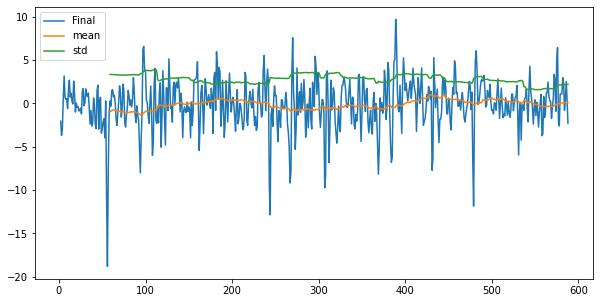

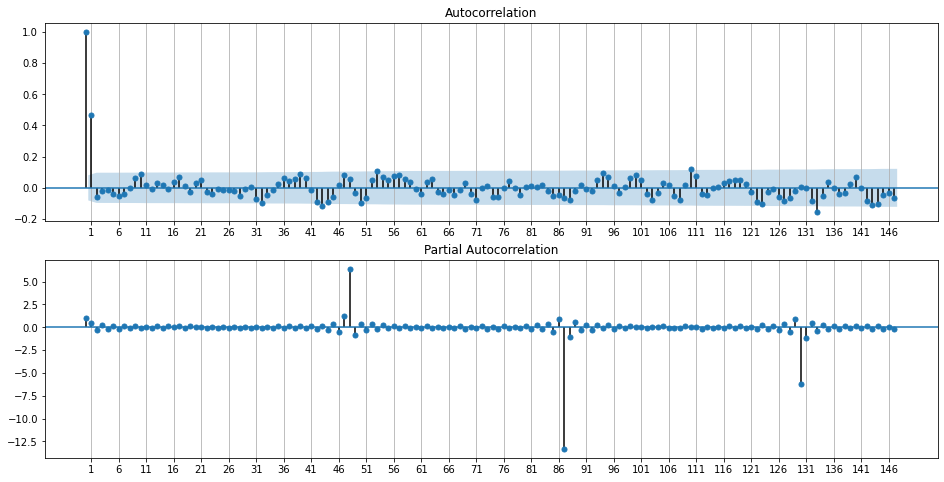

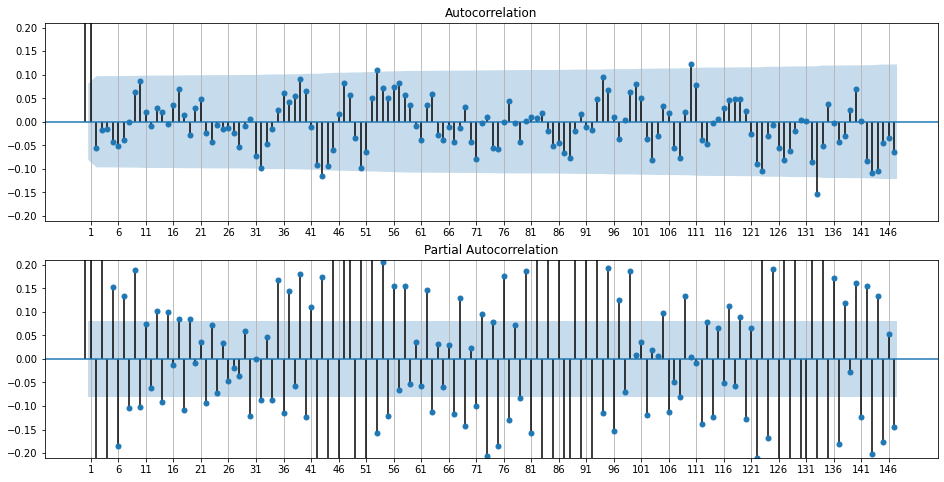


ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -4.62999
p-value                                                     0.000113689
#Lags Used                                                           18
Number of Observations Used                                         568
Critical Value (1%)            (-3.4419153151868147, Hypothesis: False)
Critical Value (5%)            (-2.8666418984730146, Hypothesis: False)
Critical Value (10%)            (-2.569487157434041, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
 
 
KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0463273
p-value                                        0.1
Lags Used                                       19
Critical Value (10%)     (0.119, Hypothesis: True)
Critical Value (5%)      (0.146, Hypothesis: True)
Critical Value (2.5%)    (0.176, Hypothesis: True)
Critical Value (1%)      (0.216, Hypothesi

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



In [ ]:
print('\n\n',sel_stock,'==========================================>')
df = sel_pd[[fvar]].dropna().copy()
df['mean'] = df[fvar].rolling(rm).mean()
df['std'] = df[fvar].rolling(rm).std()
df.plot(figsize=[10,5])
plt.show()

plotCF(df[fvar], clag, False )
plotCF(df[fvar], clag, True )


resA, resbA, dftest_, resK, resbK, kpsstest_ = stationary_test(df[fvar] , 0.05, details=True)
print(resA,'\n',resK)
print('\n Final Result::')
if not resbA: # ADF = stationary

    if resbK:   # KPSS = stationary
        print('Case 2: series is stationary\n')

    else:       # KPSS = non-stationary
        print('Case 4: difference stationary, use differencing to make series stationary\n')

else:   # ADF = non-stationary

    if not resbK: # KPSS = non-stationary
        print('Case 1: series is not stationary\n')

    else:          # KPSS = stationary
        print('Case 3: trend stationary, remove the trend to make series strict stationary\n')


## *Comments*

Serise is Non-Stationary and has trend

Can be converted to stationary serise by differencing with lag=2 

PACF shows significant lags upto 19 

ACF shows sfignificant lags upto 1

USE ARIMA(19,2,1)



---



# Stock Select : GOOGL

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


         Date        High         Low  ...       Close   Volume   Adj Close
0  2014-08-01  583.429993  570.299988  ...  573.599976  2213300  573.599976
1  2014-08-04  583.820007  572.260010  ...  582.270020  1519400  582.270020
2  2014-08-05  580.200012  570.309998  ...  573.140015  1643800  573.140015

[3 rows x 7 columns]
GOOGL 589


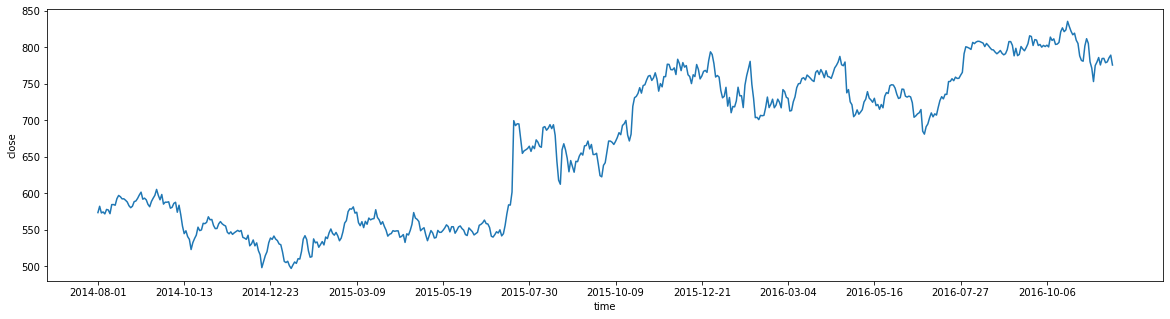

In [ ]:
sel_stock = 'GOOGL'
sel_pd = dict_pd[sel_stock]
print(sel_pd.head(3))
N = len(sel_pd)
print(sel_stock,N )

# plot selected stock
plt.figure(figsize=fgs)
plt.plot(sel_pd["Date"], sel_pd[xvar])
plt.xticks(np.arange(0,N, 50), sel_pd['Date'][0:N:50])
plt.xlabel("time")
plt.ylabel("close")
plt.show()

## Plot Record, ACF, PACF



 GOOGL ==========================================>


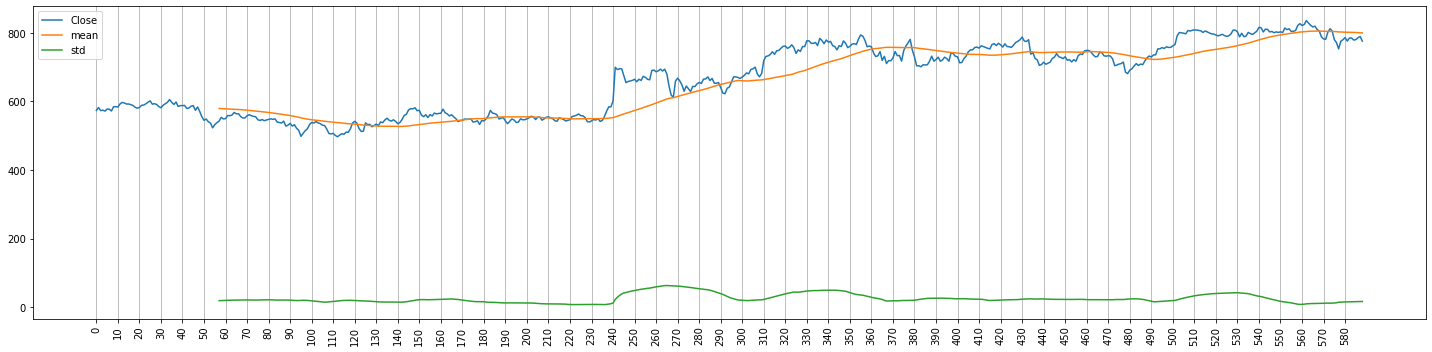

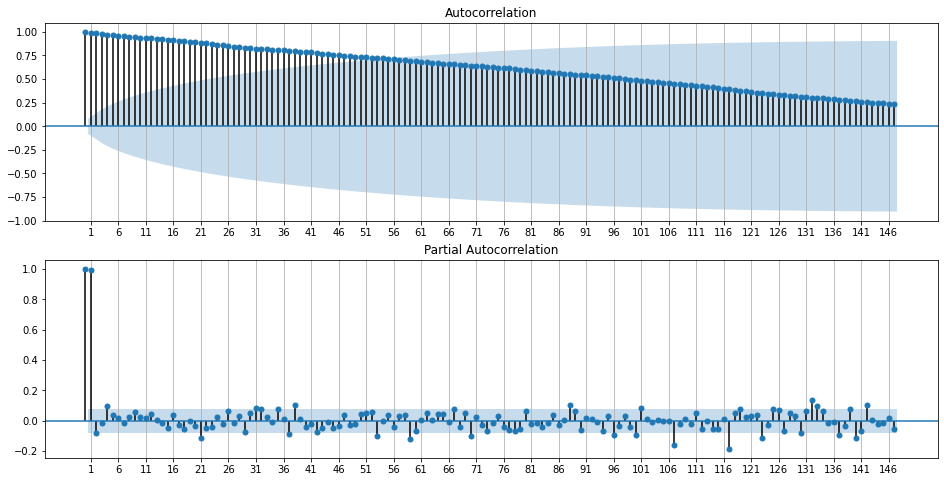

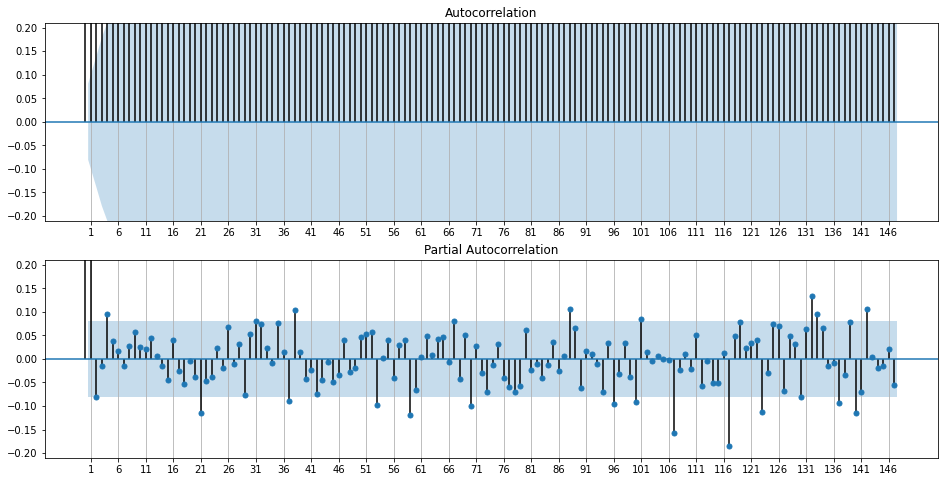

In [ ]:
print('\n\n',sel_stock,'==========================================>')
rm = int(0.1*N)

df = sel_pd[[xvar]].copy()
df['mean'] = df[xvar].rolling(rm).mean()
df['std'] =  df[xvar].rolling(rm).std()

df.plot(figsize=[20,5])
plt.xticks(np.arange(0,N,10), rotation=90)  #<---- interval of 10 obs
plt.grid(axis='x')
plt.tight_layout()
plt.show()


clag = int(.25*N)
plotCF(sel_pd[xvar], clag, False )
plotCF(sel_pd[xvar], clag, True )

## Seasonal Decompose

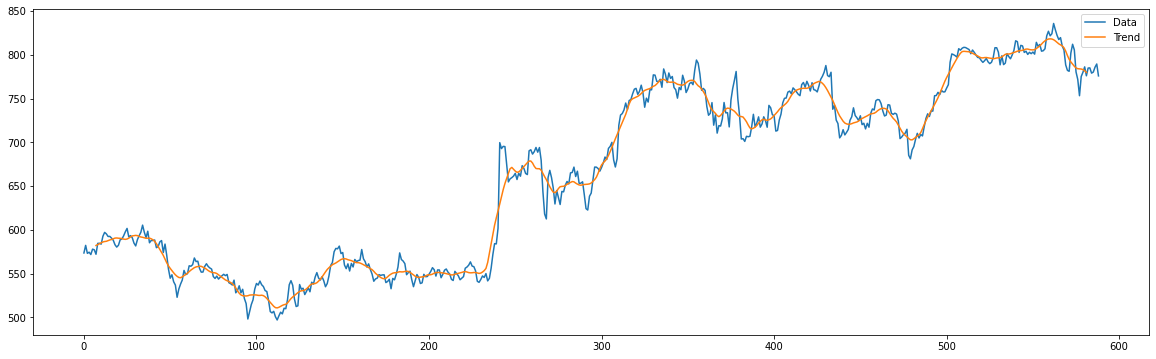

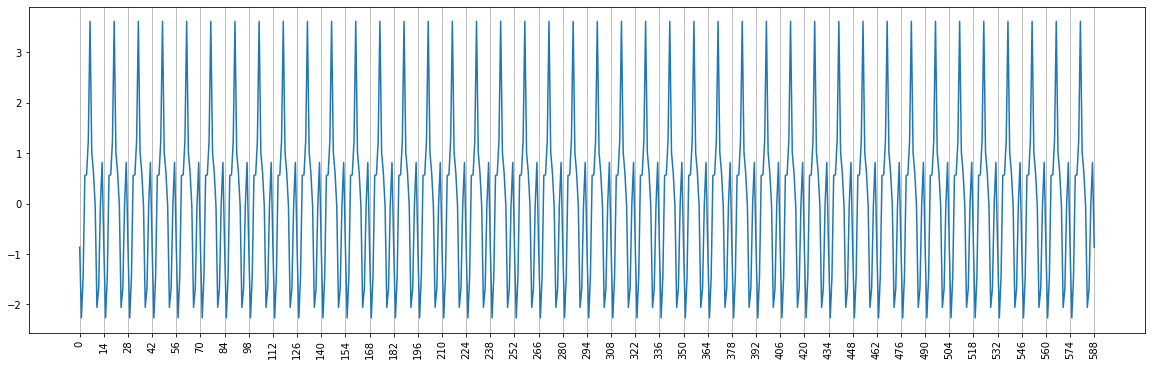

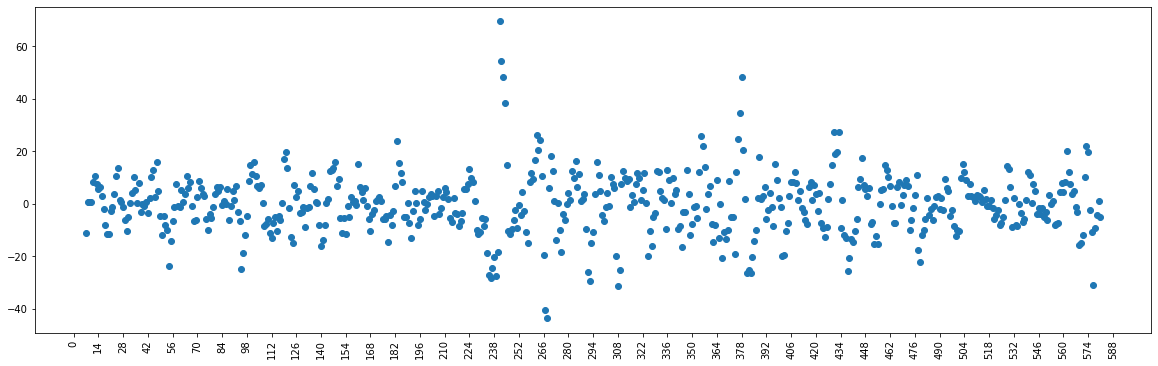

In [ ]:
dfreq=14
res = sm.tsa.seasonal_decompose(sel_pd[xvar],period=dfreq)
orig, season, trend, residual = res.observed, res.seasonal, res.trend, res.resid
xrng = np.arange(0,res.nobs[0],1)
plt.figure(figsize=(20,6))
plt.plot(orig,label='Data')
plt.plot(trend,label='Trend')
plt.legend()
plt.show()
plt.figure(figsize=(20,6))
plt.plot(season)
plt.xticks(np.arange(0,N,dfreq), rotation=90)  #<---- interval of 10 obs
plt.grid(axis='x')
plt.show()
plt.figure(figsize=(20,6))
plt.scatter(residual.keys(), residual)
plt.xticks(np.arange(0,N,dfreq), rotation=90) 
#plt.plot(residual)
plt.show()


## Check Stationarity

Case 1: Both tests conclude that the series is not stationary -> series is not stationary

Case 2: Both tests conclude that the series is stationary -> series is stationary

Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [ ]:
print('\n\n',sel_stock,'==========================================>')

resA, resbA, dftest_, resK, resbK, kpsstest_ = stationary_test(sel_pd[xvar] , 0.05, details=True)
print(resA,'\n',resK)
print('\n Final Result::')
if not resbA: # ADF = stationary

    if resbK:   # KPSS = stationary
        print('Case 2: series is stationary\n')

    else:       # KPSS = non-stationary
        print('Case 4: difference stationary, use differencing to make series stationary\n')

else:   # ADF = non-stationary

    if not resbK: # KPSS = non-stationary
        print('Case 1: series is not stationary\n')

    else:          # KPSS = stationary
        print('Case 3: trend stationary, remove the trend to make series strict stationary\n')




 GOOGL ==========================================>

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                -1.09258
p-value                                                       0.718023
#Lags Used                                                           3
Number of Observations Used                                        585
Critical Value (1%)            (-3.4415777369651717, Hypothesis: True)
Critical Value (5%)             (-2.866493255736561, Hypothesis: True)
Critical Value (10%)            (-2.569407951640003, Hypothesis: True)
dtype: object
RESULT :: Hypothesis is True
 
 
KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                             0.232866
p-value                                        0.01
Lags Used                                        19
Critical Value (10%)     (0.119, Hypothesis: False)
Critical Value (5%)      (0.146, Hypothesis: False)
Critical Value (2.5%)    (0.176, Hypothesis

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



## Convert 2 Stationary

In [ ]:
diff_period = 2
sel_pd[fvar] =  sel_pd[xvar].diff(periods=diff_period).dropna()
print('Differencing with lag =', diff_period)

sel_pd.head()

Differencing with lag = 2


,Date,High,Low,Open,Close,Volume,Adj Close,Final
0,2014-08-01,583.429993,570.299988,578.549988,573.599976,2213300,573.599976,NaN
1,2014-08-04,583.820007,572.260010,576.510010,582.270020,1519400,582.270020,NaN
2,2014-08-05,580.200012,570.309998,579.380005,573.140015,1643800,573.140015,-0.459961
3,2014-08-06,578.640015,567.450012,569.500000,574.489990,1322800,574.489990,-7.780029
4,2014-08-07,578.309998,569.429993,576.049988,571.809998,1163000,571.809998,-1.330017


### Recheck



 GOOGL ==========================================>


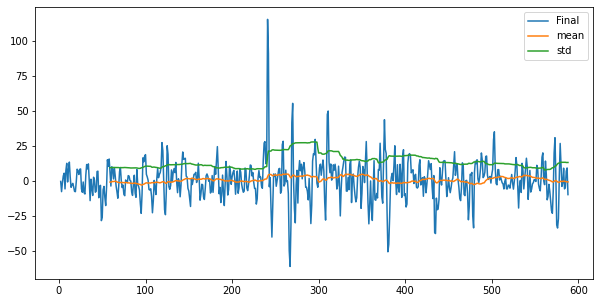

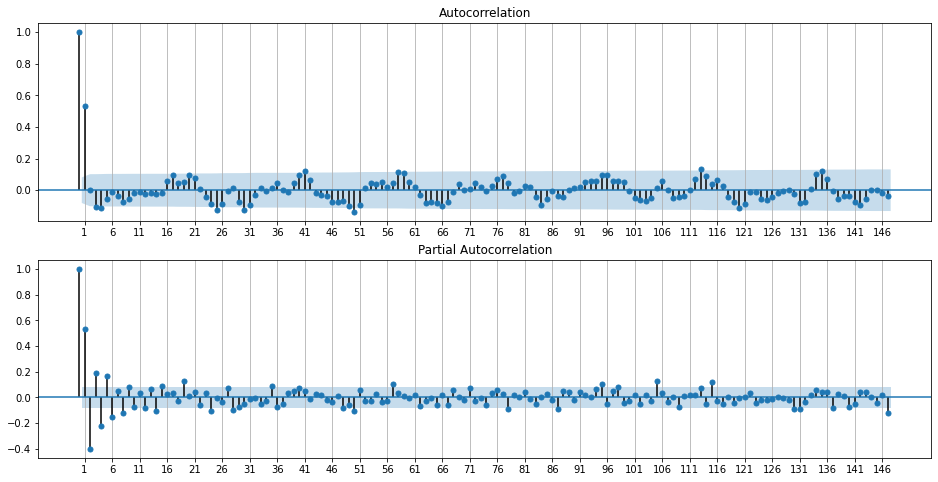

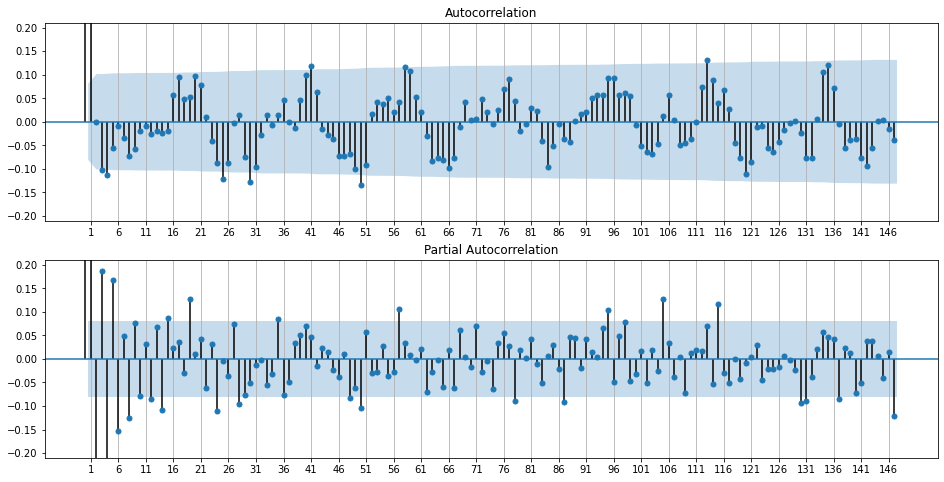


ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -4.81852
p-value                                                     5.01178e-05
#Lags Used                                                           18
Number of Observations Used                                         568
Critical Value (1%)            (-3.4419153151868147, Hypothesis: False)
Critical Value (5%)            (-2.8666418984730146, Hypothesis: False)
Critical Value (10%)            (-2.569487157434041, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
 
 
KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0712675
p-value                                        0.1
Lags Used                                       19
Critical Value (10%)     (0.119, Hypothesis: True)
Critical Value (5%)      (0.146, Hypothesis: True)
Critical Value (2.5%)    (0.176, Hypothesis: True)
Critical Value (1%)      (0.216, Hypothesi

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning:

The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"



In [ ]:
print('\n\n',sel_stock,'==========================================>')
df = sel_pd[[fvar]].dropna().copy()
df['mean'] = df[fvar].rolling(rm).mean()
df['std'] = df[fvar].rolling(rm).std()
df.plot(figsize=[10,5])
plt.show()

plotCF(df[fvar], clag, False )
plotCF(df[fvar], clag, True )


resA, resbA, dftest_, resK, resbK, kpsstest_ = stationary_test(df[fvar] , 0.05, details=True)
print(resA,'\n',resK)
print('\n Final Result::')
if not resbA: # ADF = stationary

    if resbK:   # KPSS = stationary
        print('Case 2: series is stationary\n')

    else:       # KPSS = non-stationary
        print('Case 4: difference stationary, use differencing to make series stationary\n')

else:   # ADF = non-stationary

    if not resbK: # KPSS = non-stationary
        print('Case 1: series is not stationary\n')

    else:          # KPSS = stationary
        print('Case 3: trend stationary, remove the trend to make series strict stationary\n')


## *Comments*

Serise is Non-Stationary and has trend

Can be converted to stationary serise by differencing with lag=2 

PACF shows significant lags upto 15 

ACF shows sfignificant lags upto 4

USE ARIMA(15,2,4)